# TEAM-11 Project

In [1]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from PIL import Image
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

## CustomDataset and Preprocessing

In [2]:
# paths
csv_file = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/indiana_uni_dataset/indiana_projections.csv'
image_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/images_png/'

In [63]:
data = pd.read_csv(csv_file)

# matching the images and their projection type
# adding the 'CXR' prefix to the UID and modifying the 'filename' column
data['filename'] = data['filename'].apply(lambda x: x.replace('.dcm', ''))  # Remove .dcm from the filename
data['filename'] = data.apply(lambda row: f"CXR{row['filename']}", axis=1)  # Add 'CXR' before the UID


# saving the modified CSV file
modified_csv_file = "modified_csv_file.csv"  # Output CSV file
data.to_csv(modified_csv_file, index=False)

print(f"Modified CSV saved to: {modified_csv_file}")

Modified CSV saved to: modified_csv_file.csv


In [3]:
df = pd.read_csv('modified_csv_file.csv')
df.head(3)

,uid,filename,projection
0,1,CXR1_IM-0001-4001.png,Frontal
1,1,CXR1_IM-0001-3001.png,Lateral
2,2,CXR2_IM-0652-1001.png,Frontal


In [4]:
class CustomDataset:
    def __init__(self, csv_file, image_folder, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transforms = transforms
        self.image_files = os.listdir(image_folder)

        # Preprocess data to filter entries based on occurrence count
        self.data = self.filter_data()

    def filter_data(self):
        # Extract CXR identifiers from filenames
        self.data['cxr_id'] = self.data['filename'].apply(lambda x: re.match(r'CXR\d+', x).group())

        # Count occurrences of each identifier
        cxr_counts = Counter(self.data['cxr_id'])

        # Filter out rows where cxr_id occurs only once or more than twice
        filtered_data = self.data[self.data['cxr_id'].map(cxr_counts).between(2, 2, inclusive="both")]

        # Drop the temporary column
        filtered_data = filtered_data.drop(columns=['cxr_id'])
        return filtered_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # getting the row from the filtered .csv file
        row = self.data.iloc[idx]
        csv_filename = row['filename']
        projection = row['projection']

        # finding the image file that matches the CSV filename
        image_path = os.path.join(self.image_folder, csv_filename)
        if not os.path.exists(image_path):
            print(f"Image not found for {csv_filename}")
            return None

        try:
            image = Image.open(image_path)
        except FileNotFoundError:
            print(f"Image not found at {image_path}")
            return None

        # applying transformations if any
        if self.transforms:
            image = self.transforms(image)

        return {'image_type': projection, 'image': image, 'filename': csv_filename}

In [5]:
# transforms
transforms = v2.Compose([
    v2.Resize((128,128)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

csv_file = 'modified_csv_file.csv'

# loading dataset
dataset = CustomDataset(csv_file, image_folder, transforms)

/usr4/ec500/avantk/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
# mapping frontal and lateral images based on their image IDs
frontal_mapping = {}
lateral_mapping = {}

# iterating through the dataset and populate mappings
for item in dataset:
    if item is not None:
        image_type = item['image_type']
        image = item['image']
        uid = int(item['filename'].split('_')[0][3:])  # Extract the UID from the filename

        if image_type == 'Frontal':
            frontal_mapping[uid] = image
        elif image_type == 'Lateral':
            lateral_mapping[uid] = image
        else:
            print('Unexpected type')

# extracting only the images that have both frontal and lateral biplanar views
frontal, lateral = [], []
for uid, lateral_image in lateral_mapping.items():
    if uid in frontal_mapping:
        frontal.append(frontal_mapping[uid])
        lateral.append(lateral_image)

print(f"Final counts -> Frontal: {len(frontal)}, Lateral: {len(lateral)}")


Image not found for CXR1_IM-0001-4001.png
Image not found for CXR1_IM-0001-3001.png
Final counts -> Frontal: 3193, Lateral: 3193


## GAN Part 1: Generator

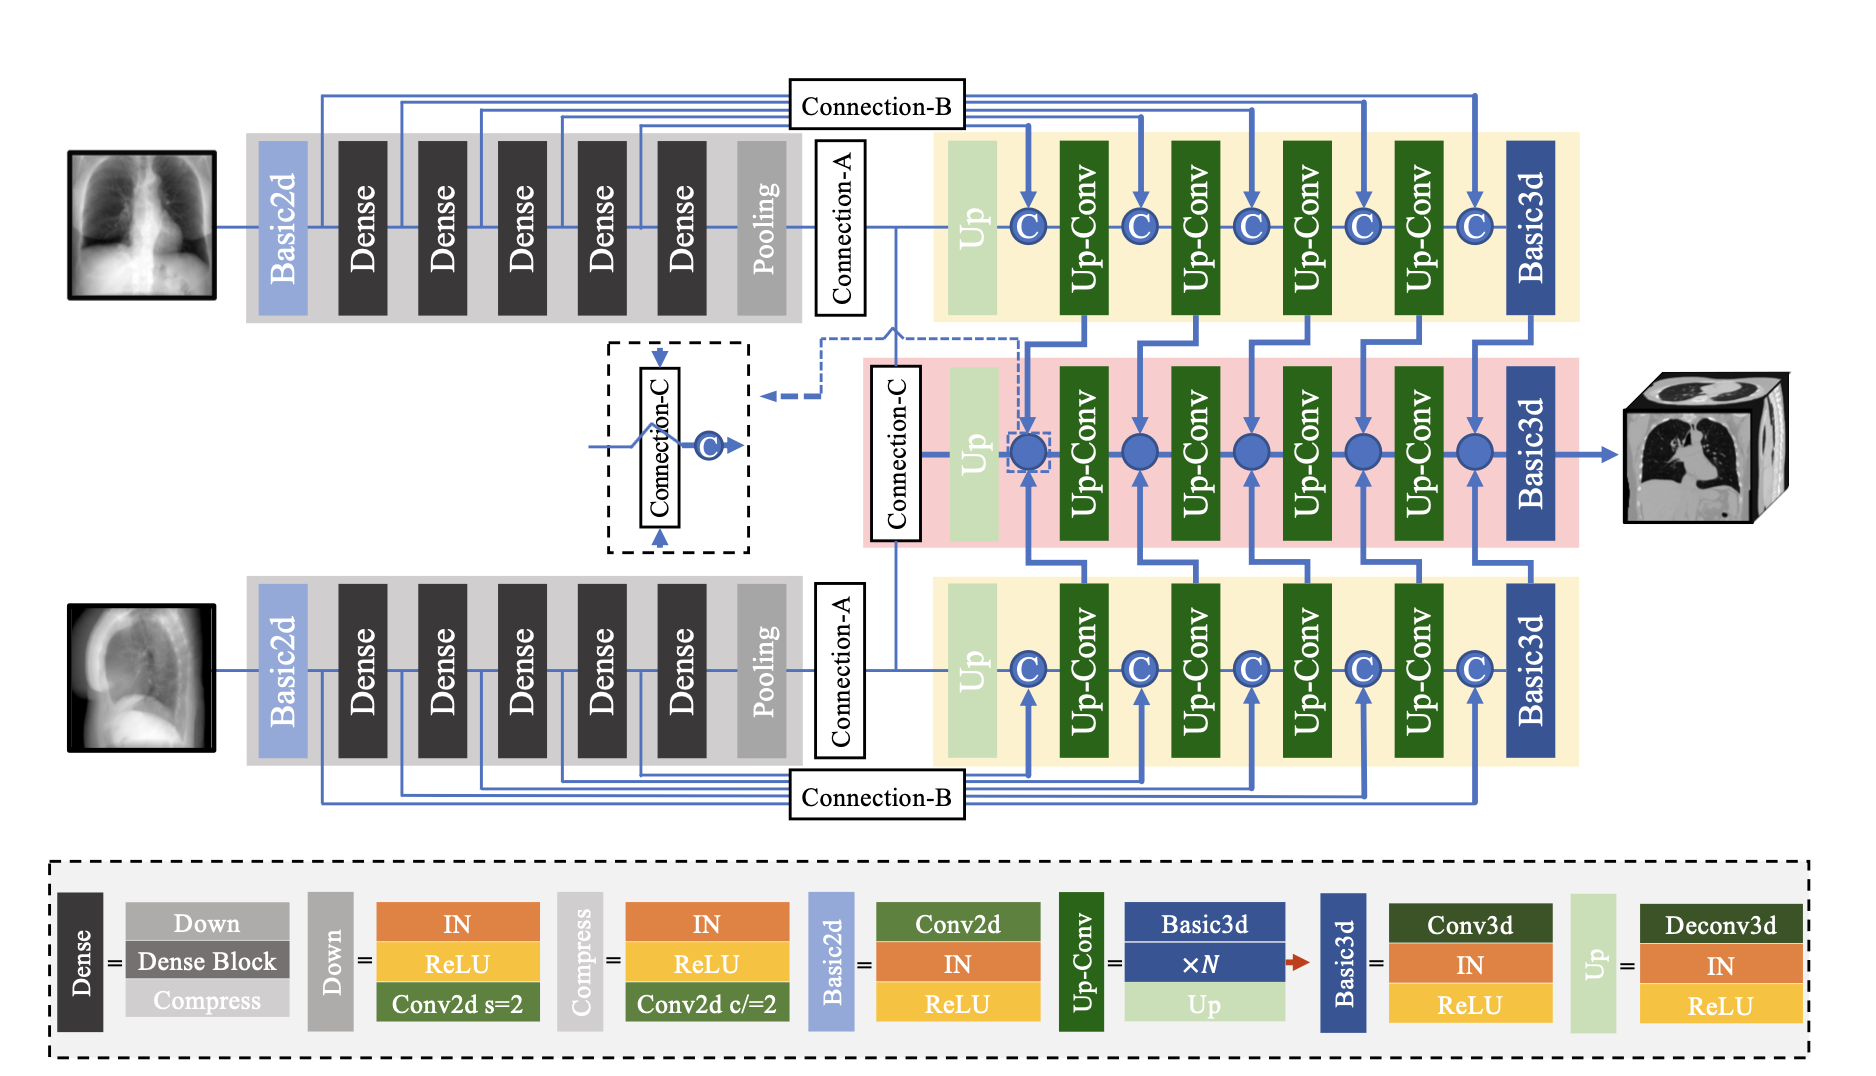

In [7]:
import torch
import torch.nn as nn

# Define a Dense Block for 2D operations
class DenseBlock2D(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock2D, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.InstanceNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1),
            ))
            in_channels += growth_rate

    def forward(self, x):
        for layer in self.layers:
            out = layer(x)
            x = torch.cat([x, out], dim=1)  # Concatenate input and output along channel dimension
        return x

# Define Basic 2D/3D Convolution Block
class BasicConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_type="2D"):
        super(BasicConvBlock, self).__init__()
        if conv_type == "2D":
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            self.norm = nn.InstanceNorm2d(out_channels)
        elif conv_type == "3D":
            self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
            self.norm = nn.InstanceNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))

# Define Up-Convolution Block
class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_type="3D"):
        super(UpConvBlock, self).__init__()
        if conv_type == "3D":
            self.upconv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        elif conv_type == "2D":
            self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.norm = nn.InstanceNorm3d(out_channels) if conv_type == "3D" else nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.norm(self.upconv(x)))

In [8]:
class GANGenerator(nn.Module):
    def __init__(self, input_channels=1, growth_rate=32, num_dense_layers=4, num_upsample=4):
        super(GANGenerator, self).__init__()

        # Frontal branch (2D)
        self.frontal_branch = nn.Sequential(
            BasicConvBlock(input_channels, growth_rate, conv_type="2D"),
            DenseBlock2D(growth_rate, growth_rate, num_dense_layers),
            nn.Conv2d(growth_rate * (num_dense_layers + 1), growth_rate, kernel_size=1),
        )

        # Lateral branch (2D)
        self.lateral_branch = nn.Sequential(
            BasicConvBlock(input_channels, growth_rate, conv_type="2D"),
            DenseBlock2D(growth_rate, growth_rate, num_dense_layers),
            nn.Conv2d(growth_rate * (num_dense_layers + 1), growth_rate, kernel_size=1),
        )

        # Shared dense encoder (2D)
        self.shared_encoder = nn.Sequential(
            nn.MaxPool2d(2),
            DenseBlock2D(growth_rate, growth_rate, num_dense_layers),
            nn.Conv2d(growth_rate * (num_dense_layers + 1), growth_rate, kernel_size=1),
        )

        # Channel reduction before passing to the decoder
        self.channel_reduction = nn.Conv2d(growth_rate, 32, kernel_size=1)

        # Decoder with 3D Up-Convolutions
        self.decoder = nn.ModuleList()
        for _ in range(num_upsample):
            self.decoder.append(nn.Sequential(
                UpConvBlock(32, 32, conv_type="3D"),
                BasicConvBlock(32, 32, conv_type="3D"),
            ))

        # Final 3D output layer (generating depth/volume)
        self.final_layer = nn.Conv3d(32, 1, kernel_size=1)  # 1 for depth or voxel

        # Final activation 
        self.final_activation = nn.Sigmoid()  

    def forward(self, frontal, lateral):
        # Process the frontal and lateral branches
        frontal_feat = self.frontal_branch(frontal)
        lateral_feat = self.lateral_branch(lateral)

        # Combine features from both branches
        combined_feat = frontal_feat + lateral_feat  
        #combined_feat = torch.cat([frontal_feat, lateral_feat], dim=1)

        # Pass through the shared encoder
        encoded_feat = self.shared_encoder(combined_feat)

        # Reduce channels before passing to decoder
        encoded_feat = self.channel_reduction(encoded_feat)

        # Reshape for decoding (adding an extra dimension for 3D)
        encoded_feat = encoded_feat.unsqueeze(2)  # Convert to 3D format

        # Decode with 3D up-convolutions
        x = encoded_feat
        for upconv in self.decoder:
            x = upconv(x)

        # Final 3D output layer
        output = self.final_layer(x)

        # Apply final activation (sigmoid/tanh)
        output = self.final_activation(output)
        
        return output


In [9]:
class FrontalLateralDataset(Dataset):
    def __init__(self, frontal, lateral, transforms=None):
        self.frontal = frontal
        self.lateral = lateral
        self.transforms = transforms

    def __len__(self):
        return len(self.frontal)

    def __getitem__(self, idx):
        frontal_image = self.frontal[idx]
        lateral_image = self.lateral[idx]

        # Apply transformations if defined
        if self.transforms:
            frontal_image = self.transforms(frontal_image)
            lateral_image = self.transforms(lateral_image)

        return frontal_image, lateral_image

In [46]:
# Create the dataset
dataset = FrontalLateralDataset(frontal, lateral)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize the generator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = GANGenerator(input_channels=3).to(device)
generator.eval()  # Set to evaluation mode

# Test the generator
with torch.no_grad():  # No need to compute gradients during testing
    for frontal_images, lateral_images in dataloader:
        frontal_images = frontal_images.to(device)
        lateral_images = lateral_images.to(device)
        
        # Generate lateral images
        generated_images = generator(frontal_images, lateral_images)



KeyboardInterrupt: 

In [71]:
len(lateral_images)

1

In [48]:
generated_images[0].shape

torch.Size([1, 16, 1024, 1024])

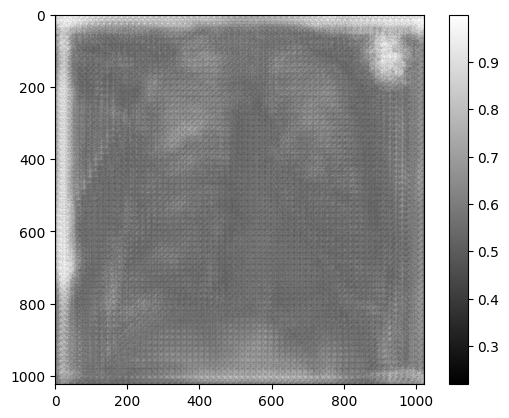

In [68]:
# Choose the first channel (index 0) to plot, or you can select another channel
channel_image = generated_images[0][0, 8, :, :].cpu().detach().numpy()

# Plot the selected channel image
plt.imshow(channel_image, cmap='gray')
plt.colorbar()
plt.show()

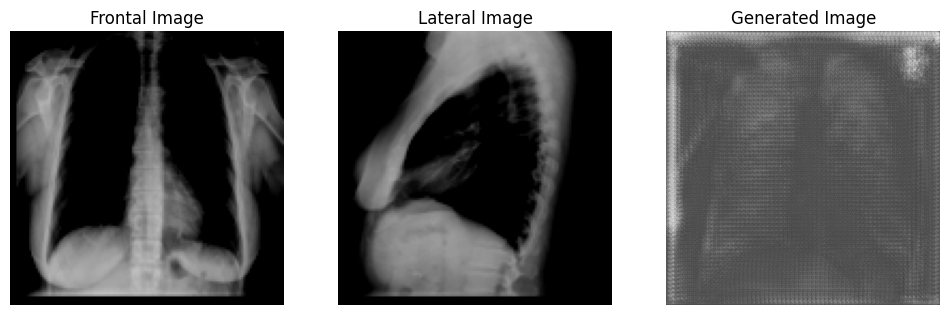

In [84]:
# Convert the images to CPU and detach from the computation graph
#frontal_images = frontal_images.cpu().squeeze().numpy().transpose(1, 2, 0)
#lateral_images = lateral_images.cpu().squeeze().numpy().transpose(1, 2, 0)
#generated_images = generated_images.cpu().squeeze().numpy().transpose(1, 2, 0)
#generated_images = generated_images[0][0, 8, :, :].detach().numpy()

# Normalize the images to [0, 1] for visualization if needed
frontal_images = np.clip(frontal_images, 0, 1)
lateral_images = np.clip(lateral_images, 0, 1)
generated_images = np.clip(generated_images, 0, 1)

# Plot the images side by side
plt.figure(figsize=(12, 4))

# Subplot for frontal image
plt.subplot(1, 3, 1)
plt.imshow(frontal_images)
plt.title("Frontal Image")
plt.axis('off')

# Subplot for lateral image
plt.subplot(1, 3, 2)
plt.imshow(lateral_images)
plt.title("Lateral Image")
plt.axis('off')

# Subplot for generated image
plt.subplot(1, 3, 3)
plt.imshow(generated_images[:,:,:1], cmap='gray')
plt.title("Generated Image")
plt.axis('off')

# Show the plot
plt.show()

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class XRayTo3DGenerator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1):
        super(XRayTo3DGenerator, self).__init__()
        
        # Input channels for frontal and lateral images (2 channels)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        
        # Upsampling to form the 3D image using deconvolution layers
        self.deconv1 = nn.ConvTranspose3d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose3d(64, out_channels, kernel_size=4, stride=2, padding=1)
        
    def forward(self, frontal_img, lateral_img):
        # Concatenate the frontal and lateral X-ray images along the channel dimension
        x = torch.cat([frontal_img, lateral_img], dim=1)
        
        # Apply convolutions
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        # Add a channel dimension for 3D deconvolution
        x = x.unsqueeze(2)  # Add a dummy dimension to simulate a 3D input (B, C, D, H, W)
        
        # Apply deconvolution (upsampling)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = self.deconv4(x)  # Output the 3D image
        
        return x

# Testing the Generator
if __name__ == '__main__':
    # Example input (batch_size=1, channels=2, height=128, width=128)
    frontal_img = torch.randn(1, 1, 128, 128)  # Single frontal image
    lateral_img = torch.randn(1, 1, 128, 128)  # Single lateral image
    
    # Instantiate the generator model
    generator = XRayTo3DGenerator()
    
    # Forward pass through the generator
    output = generator(frontal_img, lateral_img)
    
    print(f"Output shape: {output.shape}")
    # The output should have shape (1, 1, 128, 128, 128) indicating 3D image output


Output shape: torch.Size([1, 1, 16, 2048, 2048])
